In [1]:
# Constants
import string
from random import choices, choice
from datetime import datetime

INPUT_SIZE = [512, 1024, 2048, 4096]
HIDDEN_LAYERS = [1, 2]
HIDDEN_LAYER_DIVISOR = [2, 4, 8]
Z_LAYER_DIVISOR = [4, 8, 16, 32]
DROPOUT = [.1, .25, .5]
LEARNING_RATE = [0.000001, 0.00001, 0.0001]
BATCH_SIZE = [8, 16, 32]
FOLLOWER = True # Set later, false for aae, true for regular

DATA_SET = "Task 1"
TYPE = "Vanilla AE"
TIME_LENGTH = 1
DIFFERENCE_THRESHS = [.8 + 0.2 * i for i in range(25)]
ATTEMPT = 0 # Set later, doesn't make a difference

# New masking section
MASKING = [True, False]
MASK_SIZE = [.25, .5, .75]

name = datetime.now().strftime("%Y%m%d%H%M%S")

model_final_stats = {"name": name, "dataset": DATA_SET, "type": TYPE, "len": TIME_LENGTH}

print(name)

20231119181055


In [2]:
# Assign whether follower or not based on the previous models attempt
import pandas as pd

# Previous failed
previous_failed = False

try:
    open("failed", "x")
except FileExistsError:
    if FOLLOWER:
        crash()
    else:
        previous_failed = True

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
    if len(previous_trials) % 2 == 1:
        print(1)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"]
    elif previous_trials[-1]["attempt"] == 4:
        print(2)
        FOLLOWER = False
        ATTEMPT = 0
    else:
        print(3)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"] + 1
    
    if previous_failed:
        print("Prev Failed")
        FOLLOWER = False
        ATTEMPT = 0
        
        
except (FileNotFoundError, pd.errors.EmptyDataError):
    print(4)
    FOLLOWER = False
    ATTEMPT = 0

model_final_stats["attempt"] = ATTEMPT

2


In [3]:
# Pick hyperparameters
hyper_params = {
    "input_size": choice(INPUT_SIZE),
    "hidden_layers": choice(HIDDEN_LAYERS),
    "hidden_layers_divisor": choice(HIDDEN_LAYER_DIVISOR),
    "z_layer_divisor": choice(Z_LAYER_DIVISOR),
    "dropout": choice(DROPOUT),
    "learning_rate": choice(LEARNING_RATE),
    "batch_size": choice(BATCH_SIZE),
    "masking": choice(MASKING),
    "mask_size": choice(MASK_SIZE)
}
hyper_params["input_size"] *= TIME_LENGTH
hyper_params["hidden_layers_divisor"] *= TIME_LENGTH
hyper_params["z_layer_divisor"] *= TIME_LENGTH
model_final_stats["leader"] = None

if FOLLOWER:
    previous_models = pd.read_csv("ae_trials.csv", keep_default_na=False).to_dict("records")
    for model in previous_models[::-1]: # We want to find the original leader not a fake leader
        if not model["leader"]:
            model_final_stats["leader"] = model["name"]
            break
    
    for key in hyper_params.keys():
        hyper_params[key] = model[key]

model_final_stats.update(hyper_params)
print(model_final_stats)

{'name': '20231119181055', 'dataset': 'Task 1', 'type': 'Vanilla AE', 'len': 1, 'attempt': 0, 'leader': None, 'input_size': 4096, 'hidden_layers': 2, 'hidden_layers_divisor': 8, 'z_layer_divisor': 16, 'dropout': 0.5, 'learning_rate': 0.0001, 'batch_size': 8, 'masking': True, 'mask_size': 0.25}


In [4]:
# Load datasets
from pickle import load
from random import sample

x_tests, y_tests = load(open("data/test_%d_%d.pickle" % (hyper_params["input_size"], model_final_stats["len"]), "rb"))
x_tests = [[x - 0.5 for x in sample] for sample in x_tests[ATTEMPT]]
y_tests = y_tests[ATTEMPT]

x_train = load(open("data/train_%d_%d.pickle" % (hyper_params["input_size"], model_final_stats["len"]), "rb"))
x_train = [[x - 0.5 for x in sample] for sample in x_train[ATTEMPT]]
print(len(x_train))

# Mask x_tests and y_tests
if hyper_params["masking"]:
    # print(int(hyper_params["input_size"] * hyper_params["mask_size"]), hyper_params["input_size"])
    # print(len(x_tests))
    x_tests = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_tests]
    x_train = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_train]

x_tests, y_tests = [x_tests], [y_tests]

55


In [5]:
print(len([x[0] for x in x_train]))

55


In [6]:
# Create encoder model
from tensorflow.keras import models, layers

encoder = models.Sequential()

if hyper_params["masking"]:
    encoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    encoder.add(layers.Input(shape=hyper_params["input_size"]))

for i in range(hyper_params["hidden_layers"]):
    encoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    encoder.add(layers.Dropout(hyper_params["dropout"]))
encoder.add(layers.Dense(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))

encoder.summary()

2023-11-19 18:10:56.157980: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 18:10:56.207031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 18:10:56.798130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              4198400   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 455)               1864135   
                                                                 
 dropout_1 (Dropout)         (None, 455)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               116736    
                                                                 
Total params: 6179271 (23.57 MB)
Trainable params: 6179271 (23.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-19 18:10:57.673433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-11-19 18:10:57.673992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22192 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [7]:
# Create decoder model

decoder = models.Sequential()
decoder.add(layers.Input(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))
for i in list(range(hyper_params["hidden_layers"]))[::-1]:
    decoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    decoder.add(layers.Dropout(hyper_params["dropout"]))
decoder.add(layers.Dense(hyper_params["input_size"]))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 455)               116935    
                                                                 
 dropout_2 (Dropout)         (None, 455)               0         
                                                                 
 dense_4 (Dense)             (None, 4096)              1867776   
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              16781312  
                                                                 
Total params: 18766023 (71.59 MB)
Trainable params: 18766023 (71.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Create autoencoder model

autoencoder = models.Sequential()

if hyper_params["masking"]:
    autoencoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    autoencoder.add(layers.Input(shape=hyper_params["input_size"]))

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               6179271   
                                                                 
 sequential_1 (Sequential)   (None, 4096)              18766023  
                                                                 
Total params: 24945294 (95.16 MB)
Trainable params: 24945294 (95.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/300


2023-11-19 18:10:58.957262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-19 18:10:58.999154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8b05060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 18:10:58.999199: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-19 18:10:58.999214: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-19 18:10:59.011784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 18:10:59.047811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-19 18:10

7/7 [==============================] - 2s 85ms/step - loss: 0.0428 - val_loss: 0.0211
Epoch 2/300
7/7 [==============================] - 0s 22ms/step - loss: 0.0414 - val_loss: 0.0206
Epoch 3/300
7/7 [==============================] - 0s 22ms/step - loss: 0.0394 - val_loss: 0.0202
Epoch 4/300
7/7 [==============================] - 0s 21ms/step - loss: 0.0376 - val_loss: 0.0197
Epoch 5/300
7/7 [==============================] - 0s 20ms/step - loss: 0.0355 - val_loss: 0.0191
Epoch 6/300
7/7 [==============================] - 0s 23ms/step - loss: 0.0340 - val_loss: 0.0183
Epoch 7/300
7/7 [==============================] - 0s 25ms/step - loss: 0.0322 - val_loss: 0.0173
Epoch 8/300
7/7 [==============================] - 0s 25ms/step - loss: 0.0303 - val_loss: 0.0159
Epoch 9/300
7/7 [==============================] - 0s 23ms/step - loss: 0.0278 - val_loss: 0.0143
Epoch 10/300
7/7 [==============================] - 0s 21ms/step - loss: 0.0266 - val_loss: 0.0129
Epoch 11/300
7/7 [=============

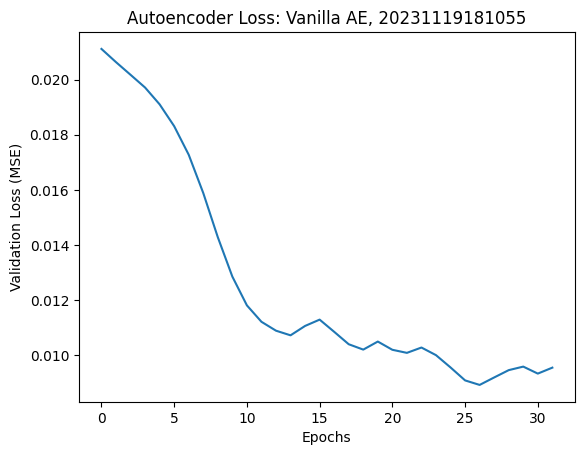

In [9]:
# Fit model and save weights
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import numpy as np

opt = optimizers.Adam(learning_rate=hyper_params["learning_rate"])
autoencoder.compile(opt, loss="mse")

if hyper_params["masking"]:
    y_train = np.array([x[0] for x in x_train]).reshape(len(x_train), hyper_params["input_size"])
    x_train = np.array([x[1] for x in x_train]).reshape(len(x_train), int(hyper_params["input_size"] * hyper_params["mask_size"]))
    
    fit_run = autoencoder.fit(
        x_train,
        y_train,
        epochs=300,
        batch_size=hyper_params["batch_size"],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], validation_split=0.1
    )
else:
    x_train = np.array(x_train).reshape(len(x_train), hyper_params["input_size"])
    
    fit_run = autoencoder.fit(
        x_train,
        x_train,
        epochs=300,
        batch_size=hyper_params["batch_size"],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], validation_split=0.1
    )


autoencoder.save_weights("ae_saved/%s" % name)
final_loss = fit_run.history["val_loss"][-1]

ae_res = {"gen_loss": None, "disc_loss": None, "val_loss": fit_run.history["val_loss"][-1], "epochs": len(fit_run.history["val_loss"])}
model_final_stats.update(ae_res)

print(ae_res)
plt.plot(range(len(fit_run.history["val_loss"])), fit_run.history["val_loss"])
plt.title("Autoencoder Loss: %s, %s" % (TYPE, name))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.show()

In [10]:
# Save splits of z layers, run difference classifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tensorflow.keras.losses import MeanSquaredError
from statistics import mean

mse = MeanSquaredError()

# Copied from latent layer classifiers
def save_results(name, hyper_params, metrics, model_name):
    try:
        previous_trials = pd.read_csv("latent_trials.csv").to_dict("records")
    except (FileNotFoundError, pd.errors.EmptyDataError):
        previous_trials = []

    model_final_stats = {"Classifier": name, "Based on AE": model_name}
    model_final_stats.update(hyper_params)
    
    model_final_stats["precision"] = metrics[0]
    model_final_stats["recall"] = metrics[1]
    model_final_stats["f-score"] = metrics[2]
    
    previous_trials.append(model_final_stats)
    pd.DataFrame(previous_trials).to_csv("latent_trials.csv", index=None)
    
    print(model_final_stats)

for split, x_test, y_test in zip(range(len(x_tests)), x_tests, y_tests):

    if hyper_params["masking"]:
        z_layers = encoder.predict(np.array([x[1] for x in x_test]).reshape(len(x_test), int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        z_layers = encoder.predict(np.array(x_test).reshape(len(x_test), hyper_params["input_size"]))
    
    outputs = decoder.predict(z_layers).tolist()
    print(y_test[0])
    class_true = [[np.argmax(y)] for y in y_test]
    
    z_layers = [y + z.tolist() for z, y in zip(z_layers, class_true)]
    pd.DataFrame(z_layers).to_pickle("z_layers/%s.pickle.gzip" % (name))
    print("Saved z-layers for %s" % split)
    
    for i, sigma in enumerate(DIFFERENCE_THRESHS):
        results = [[], []]
        for y_pred, y_true, y_class in zip(outputs, x_test, class_true):
            results[0].append(y_class)
            results[1].append(1 if mse(y_pred, y_true[0]).numpy() > sigma * final_loss else 0)
        save_results("ReconstructionThreshold", {"sigma": sigma}, list(precision_recall_fscore_support(results[0], results[1], average="binary"))[:3], name)
    print("Done with split %s" % split)

1/1 [==============================] - 0s 41ms/step
(0, 1)
Saved z-layers for 0
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 0.8, 'precision': 0.7142857142857143, 'recall': 0.625, 'f-score': 0.6666666666666666}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 1.0, 'precision': 0.7692307692307693, 'recall': 0.625, 'f-score': 0.6896551724137931}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 1.2000000000000002, 'precision': 0.8888888888888888, 'recall': 0.5, 'f-score': 0.64}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 1.4000000000000001, 'precision': 0.8571428571428571, 'recall': 0.375, 'f-score': 0.5217391304347825}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 1.6, 'precision': 1.0, 'recall': 0.3125, 'f-score': 0.47619047619047616}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181

/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 3.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 4.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 4.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 4.4, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 4.6000000000000005, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 4.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 5.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 5.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 5.4, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20231119181055', 'sigma': 5.6000000000000005, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
Done with split 0


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 17ms/step


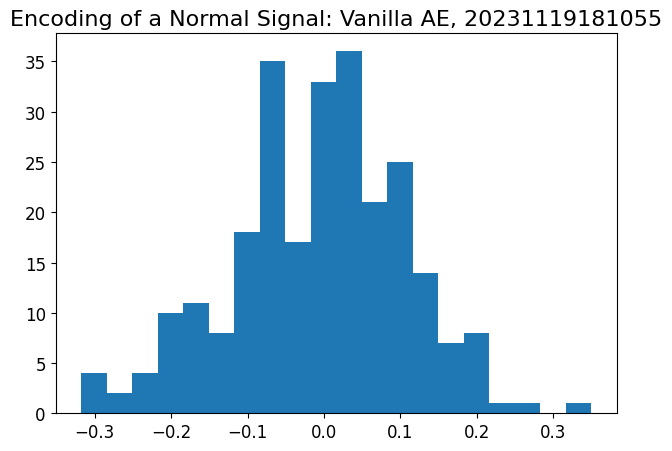

1/1 [==============================] - 0s 17ms/step


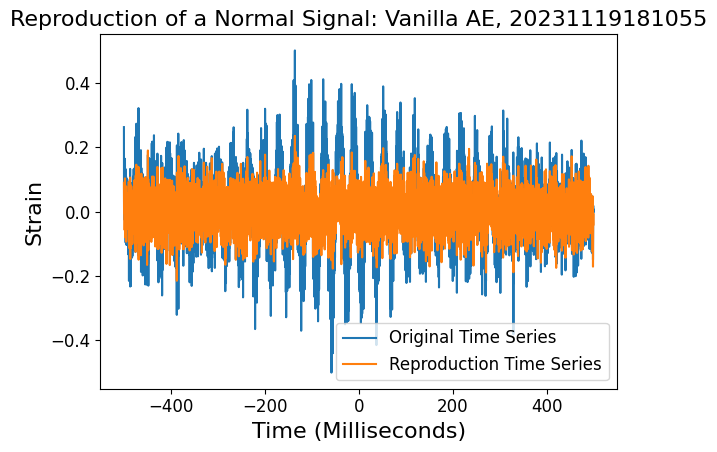

1/1 [==============================] - 0s 17ms/step


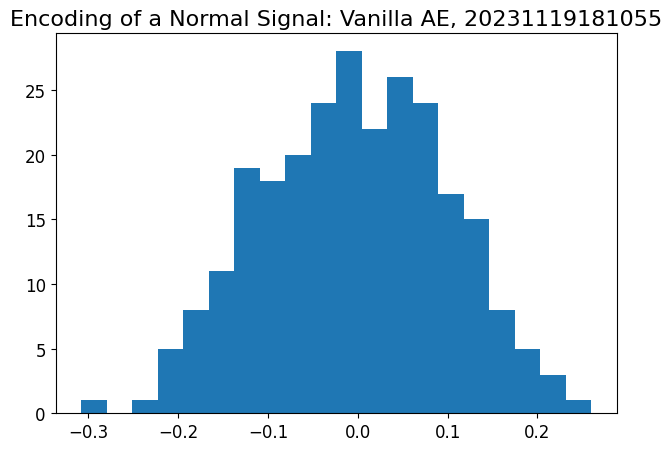

1/1 [==============================] - 0s 17ms/step


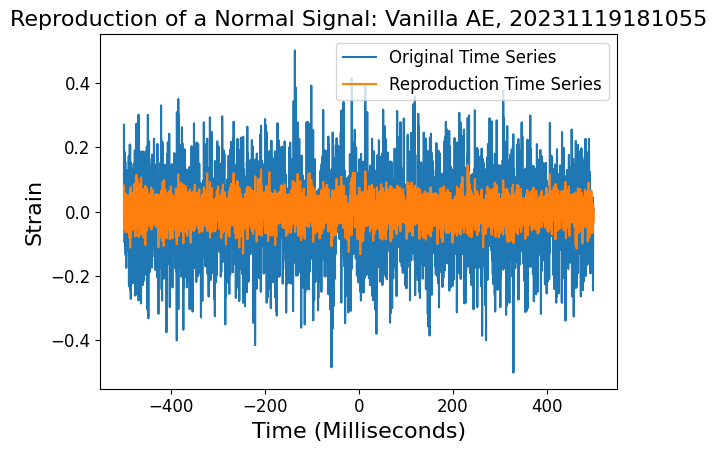

1/1 [==============================] - 0s 17ms/step


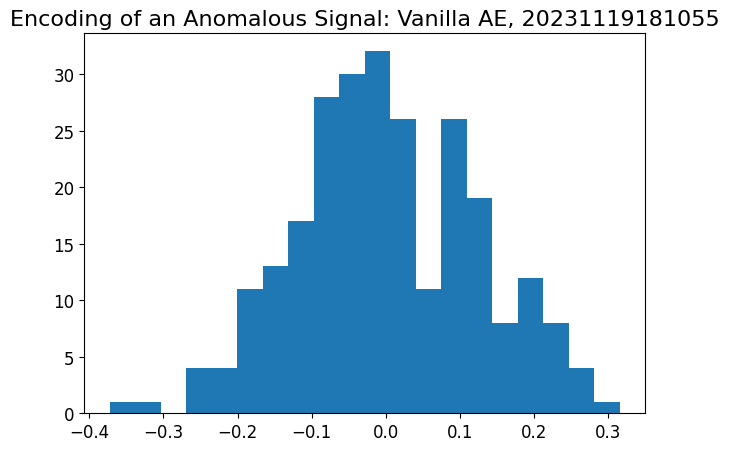

1/1 [==============================] - 0s 17ms/step


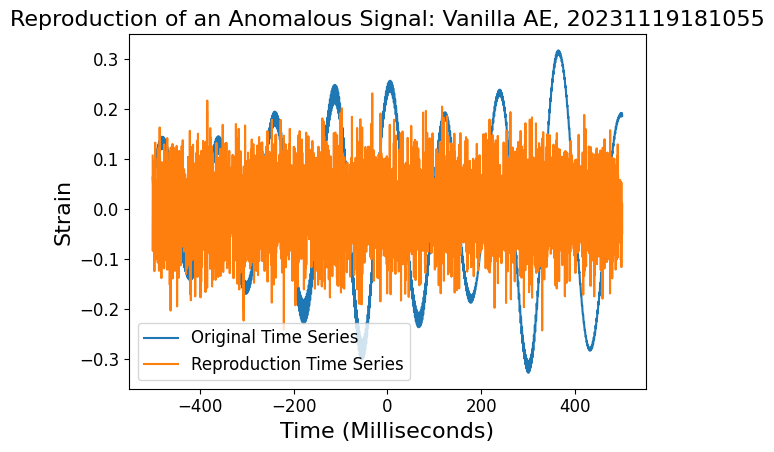

1/1 [==============================] - 0s 17ms/step


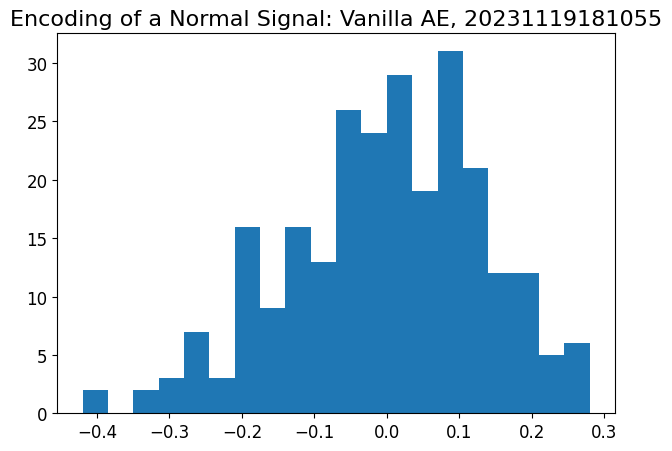

1/1 [==============================] - 0s 17ms/step


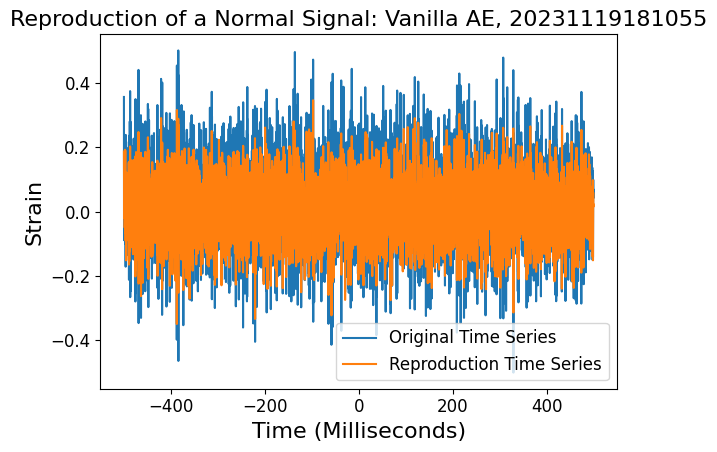

1/1 [==============================] - 0s 18ms/step


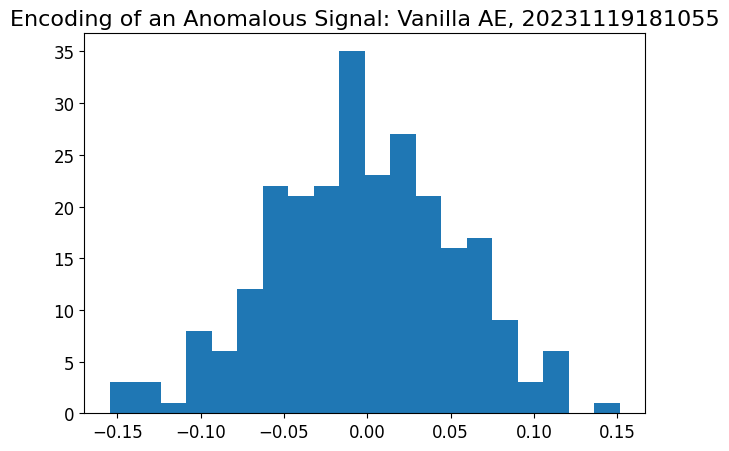

1/1 [==============================] - 0s 17ms/step


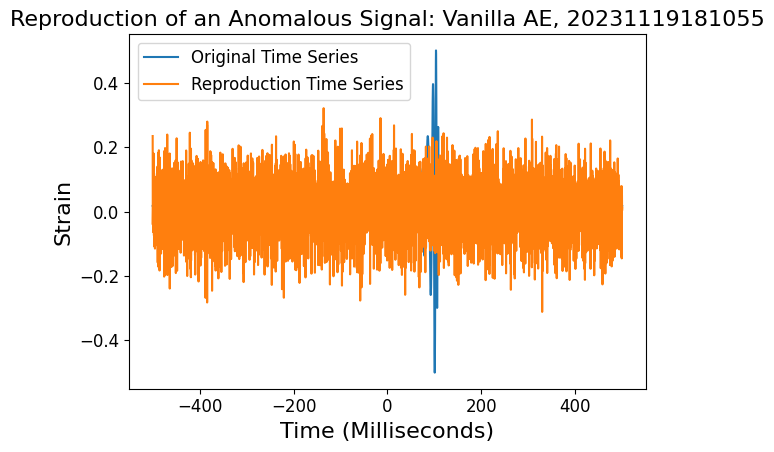

1/1 [==============================] - 0s 17ms/step


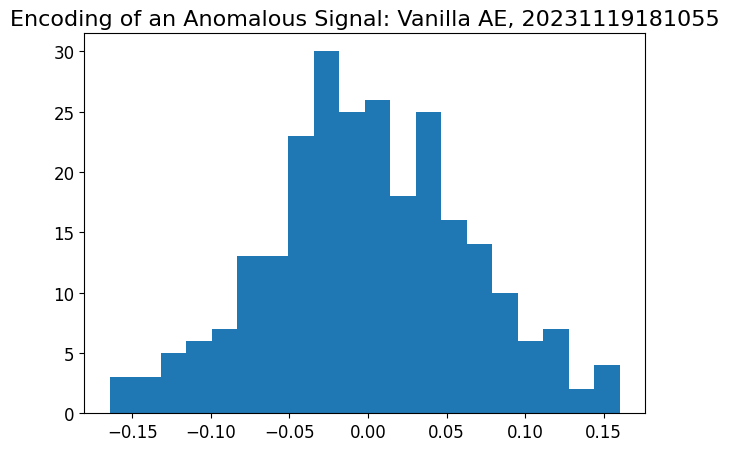

1/1 [==============================] - 0s 18ms/step


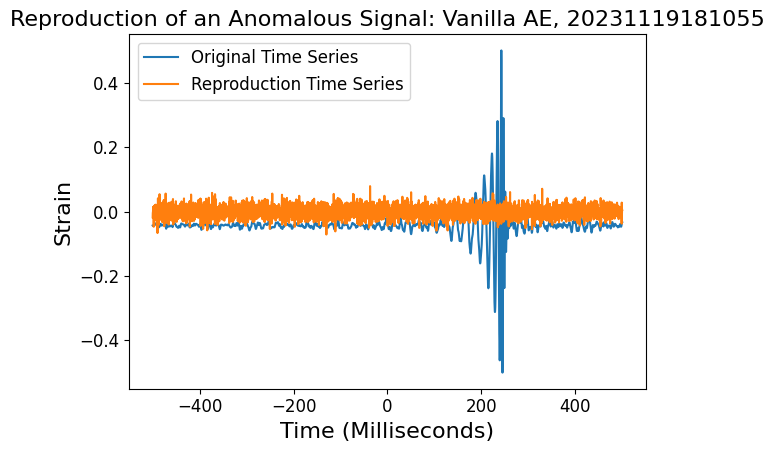

1/1 [==============================] - 0s 17ms/step


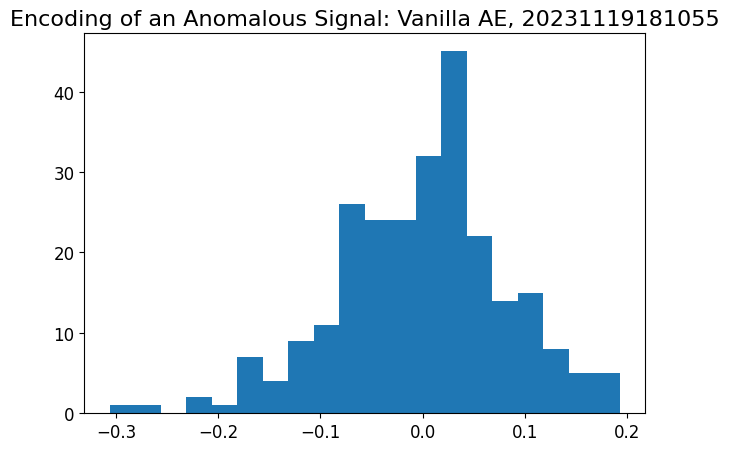

1/1 [==============================] - 0s 17ms/step


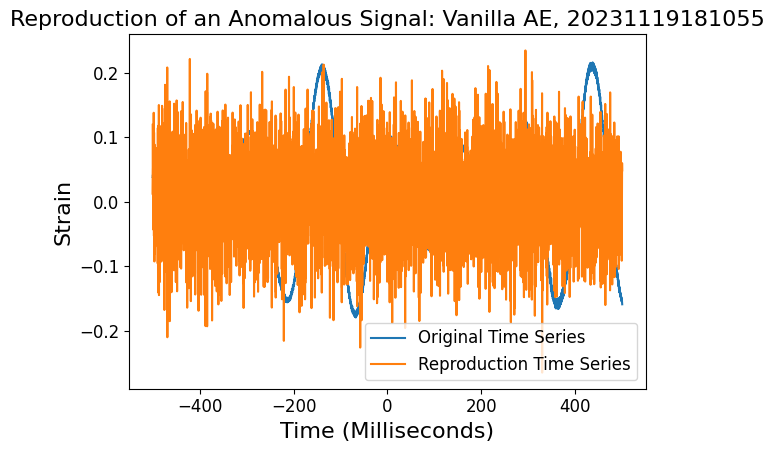

1/1 [==============================] - 0s 17ms/step


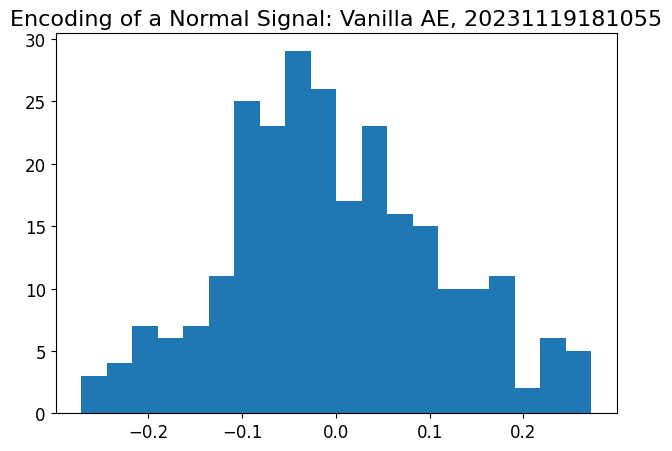

1/1 [==============================] - 0s 18ms/step


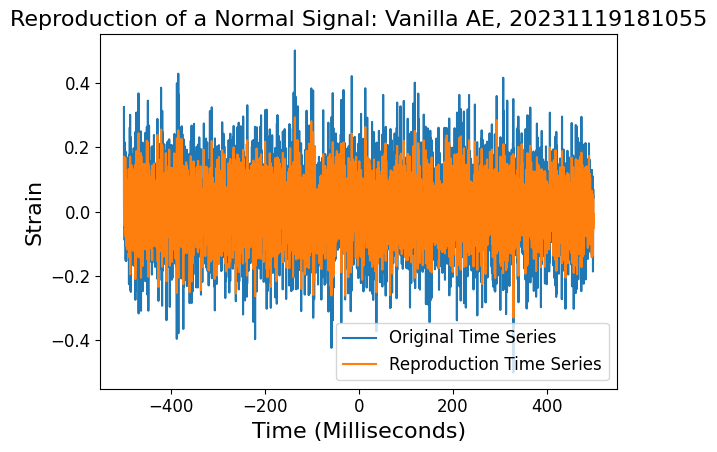

1/1 [==============================] - 0s 17ms/step


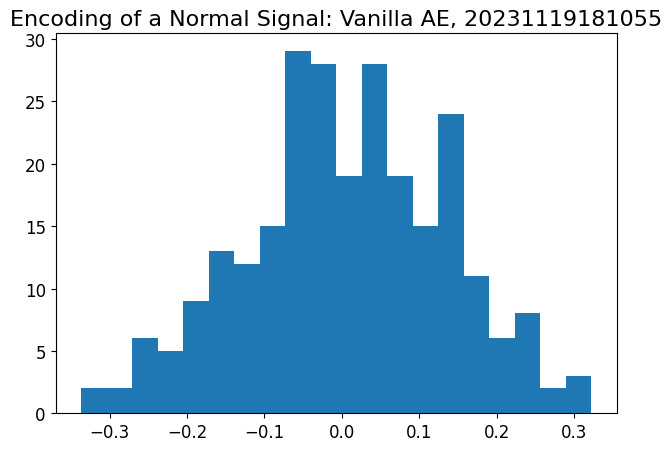

1/1 [==============================] - 0s 17ms/step


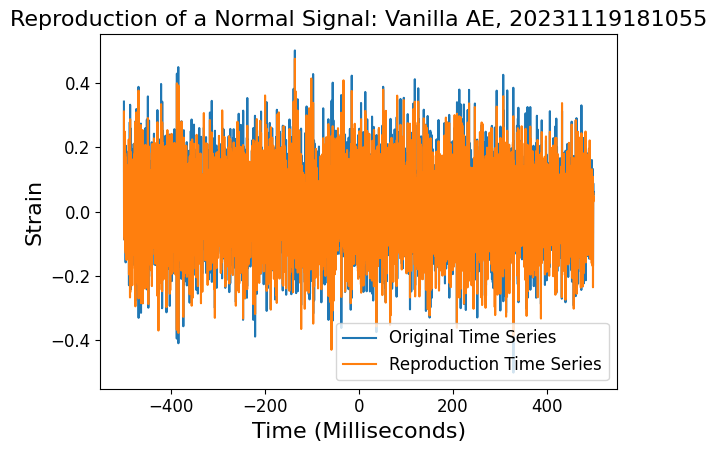

1/1 [==============================] - 0s 17ms/step


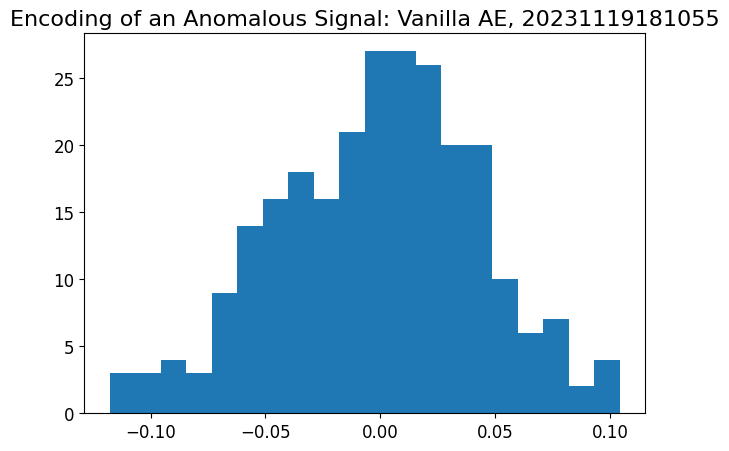

1/1 [==============================] - 0s 17ms/step


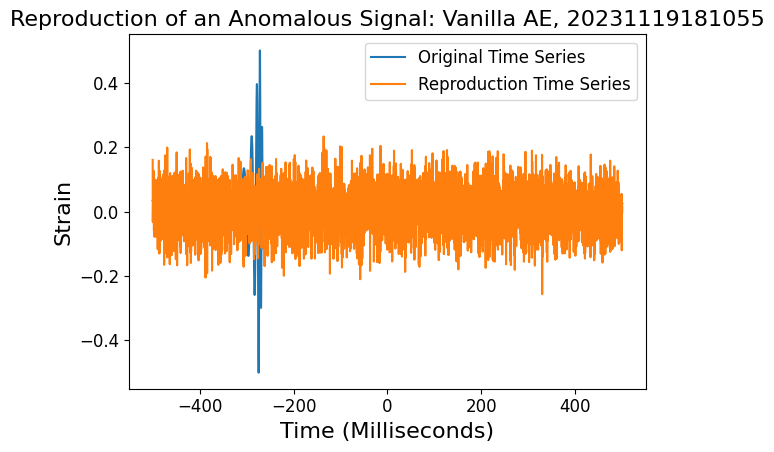

In [11]:
# Plot five graphs
from random import shuffle

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

tests_for_graph = [(x, y) for x, y in zip(x_tests[0], y_tests[0])]
shuffle(tests_for_graph)

for x, y in tests_for_graph[:10]:
    if hyper_params["masking"]:
        encoded_x = encoder.predict(np.array(x[1]).reshape(1, int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        encoded_x = encoder.predict(np.array(x).reshape(1, hyper_params["input_size"]))
    
    plt.hist(encoded_x.tolist()[0], bins=20)
    plt.title("Encoding of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.tight_layout()
    plt.show()
    
    if hyper_params["masking"]:
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], x[0], label="Original Time Series")
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    else:
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], x, label="Original Time Series")
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    
    plt.legend()
    plt.title("Reproduction of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.xlabel("Time (Milliseconds)")
    plt.ylabel("Strain")
    plt.tight_layout()
    plt.show()

In [12]:
# Save data to file

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
except (FileNotFoundError, pd.errors.EmptyDataError):
    previous_trials = []

previous_trials.append(model_final_stats)
pd.DataFrame(previous_trials).to_csv("ae_trials.csv", index=None)

In [13]:
# Remove Temp Lock
import os

os.remove("failed")